In [73]:
import re
import random
import pandas as pd
import hashlib

In [74]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()  # Truncate to first 12 characters


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].sum() > 2e4: age_factor = 1
else: age_factor = 1.00

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.75) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]


cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('age')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [75]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,head_count
Vocab,301.621491,27.420136,11
PnP Powershell,311.589270,8.199718,38
Azure Functions + Visual Studio,329.977022,23.569787,14
Audit Report Tracker (Sharepoint List),345.031141,21.564446,16
Taxes,380.949368,95.237342,4
OData,490.236312,35.016879,14
Debugging in VS Code,542.823321,23.601014,23
Azure AI Search,564.972804,40.355200,14
Powershell Modules,918.669889,30.622330,30
Logging in Python,1014.453054,40.578122,25


# Histogram

45178.87


<Axes: >

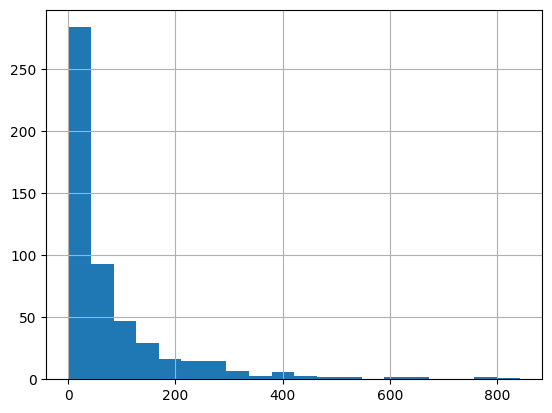

In [76]:
print(f"{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [77]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [78]:
existing_cards = existing_cards.sort_values('age', ascending=False)
remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
existing_cards.head(10)

Cards found: 529


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll
34,Azure Kubernetes Learning Path,Docker provides us with the docker stats comma...,93ee34d4f71280bfb58614e82f4ad73a,841.967215,228.858199,841.967215,3204.014787,0.606443
4,Azure AI Foundry,Compute and quota allocation is managed as sha...,beb447d769b004f37eb5bf2ed80915c2,776.321202,231.302636,776.321202,1850.421091,0.942044
48,Email Auth and Security,p=reject\n\nA DMARC policy action.\nInstructs ...,d146dc2d7b2ea73dec474121100ef003,763.644544,125.766309,763.644544,1760.728323,0.298803
5,Azure AI Foundry,"When using Azure AI Foundry portal, you can di...",6a609b8085870b5f2159093a52131196,637.216080,231.302636,776.321202,1850.421091,0.942044
136,DNS,Conditional Forwarders vs. DNS Policies\nCondi...,9c3b0ec36828c4141f3d49f0f3fc4b98,637.181036,105.312006,637.181036,1790.304094,0.686295
12,Search Engine Optimization,Link building is the practice of acquiring bac...,0016cbf46227a4d7dfbe421b0ff4d8b8,600.634800,179.280829,600.634800,1972.089117,0.226167
188,Jane Eyre,Croquant\n(kroh-KAHN) A crispy or crunchy Fren...,acbb6a996097bfe0aba58676cd8906f8,590.185045,165.824989,590.185045,3150.674784,0.575673
170,Powershell,Start-Process\nRuns an executable or script as...,ae8b6750da37f08692f19db10bb4236b,547.617514,151.691415,547.617514,2730.445477,0.125010
189,Jane Eyre,Blackaviced\n(BLACK-uh-vist) Having a dark or ...,02dea352318e4c1925efa0babb4b6d58,532.498635,165.824989,590.185045,3150.674784,0.575673
35,Azure Kubernetes Learning Path,1. A container is launched using the --publish...,bdf9678837f298b5848a372aedc0d3be,505.311823,228.858199,841.967215,3204.014787,0.606443


# Headers with fewest notes first

In [79]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

# Focus on one header

In [80]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [81]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [82]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest age sum first

In [83]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle

## Random

In [84]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

## Age Sum

In [85]:
# n=4
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)
# existing_cards.head(10)

# remake_card_document(existing_cards=existing_cards)

## Age Max

In [86]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [87]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)



## Card Count

In [88]:
# n=4
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)



In [89]:
existing_cards.head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll
34,Azure Kubernetes Learning Path,Docker provides us with the docker stats comma...,93ee34d4f71280bfb58614e82f4ad73a,841.967215,228.858199,841.967215,3204.014787,0.606443
4,Azure AI Foundry,Compute and quota allocation is managed as sha...,beb447d769b004f37eb5bf2ed80915c2,776.321202,231.302636,776.321202,1850.421091,0.942044
48,Email Auth and Security,p=reject\n\nA DMARC policy action.\nInstructs ...,d146dc2d7b2ea73dec474121100ef003,763.644544,125.766309,763.644544,1760.728323,0.298803
5,Azure AI Foundry,"When using Azure AI Foundry portal, you can di...",6a609b8085870b5f2159093a52131196,637.216080,231.302636,776.321202,1850.421091,0.942044
136,DNS,Conditional Forwarders vs. DNS Policies\nCondi...,9c3b0ec36828c4141f3d49f0f3fc4b98,637.181036,105.312006,637.181036,1790.304094,0.686295
12,Search Engine Optimization,Link building is the practice of acquiring bac...,0016cbf46227a4d7dfbe421b0ff4d8b8,600.634800,179.280829,600.634800,1972.089117,0.226167
188,Jane Eyre,Croquant\n(kroh-KAHN) A crispy or crunchy Fren...,acbb6a996097bfe0aba58676cd8906f8,590.185045,165.824989,590.185045,3150.674784,0.575673
170,Powershell,Start-Process\nRuns an executable or script as...,ae8b6750da37f08692f19db10bb4236b,547.617514,151.691415,547.617514,2730.445477,0.125010
189,Jane Eyre,Blackaviced\n(BLACK-uh-vist) Having a dark or ...,02dea352318e4c1925efa0babb4b6d58,532.498635,165.824989,590.185045,3150.674784,0.575673
35,Azure Kubernetes Learning Path,1. A container is launched using the --publish...,bdf9678837f298b5848a372aedc0d3be,505.311823,228.858199,841.967215,3204.014787,0.606443


In [90]:
existing_cards.head(10)['age'].sum()

6432.577894778368